In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
pd.set_option('display.max_columns',None)

# Carregando dados de Airbnb

O Dataframe listings contém informações de diversos tipos de room oferecidos no Airbnb, assim como do seus respectivos Hosts.

In [3]:
with gzip.open('listings.csv.gz') as f:
    listings = pd.read_csv(f)

In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25784 entries, 0 to 25783
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25784 non-null  int64  
 1   listing_url                                   25784 non-null  object 
 2   scrape_id                                     25784 non-null  int64  
 3   last_scraped                                  25784 non-null  object 
 4   name                                          25755 non-null  object 
 5   description                                   24423 non-null  object 
 6   neighborhood_overview                         14109 non-null  object 
 7   picture_url                                   25784 non-null  object 
 8   host_id                                       25784 non-null  int64  
 9   host_url                                      25784 non-null 

# Objetivo

 A questão que vamos tentar resolver é a de classificação do room type (feature ‘room_type’) a partir de outras features no arquivo Listings.

# Exploracao de Dados

Em um step inicial verificamos quais tipos de variaveis são possiveis para nossa variável resposta 'room_type'

In [5]:
listings['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

Verificamos que grande maioria de rooms são da classe Entire home/apt e Private Room

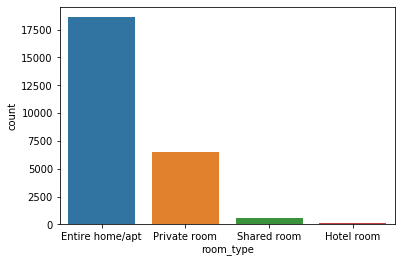

In [6]:
sns.countplot(x='room_type',data=listings)

Transformando a variavel categorica 'room_type' em uma dummy variable para podermos analisar correlacoes

In [7]:
listings = pd.concat([listings, pd.get_dummies(listings['room_type'],prefix='output')],axis=1)

Através de um heatmap analisamos a correlação dos diferentes room_types com as variaveis numericas disponiveis em listings

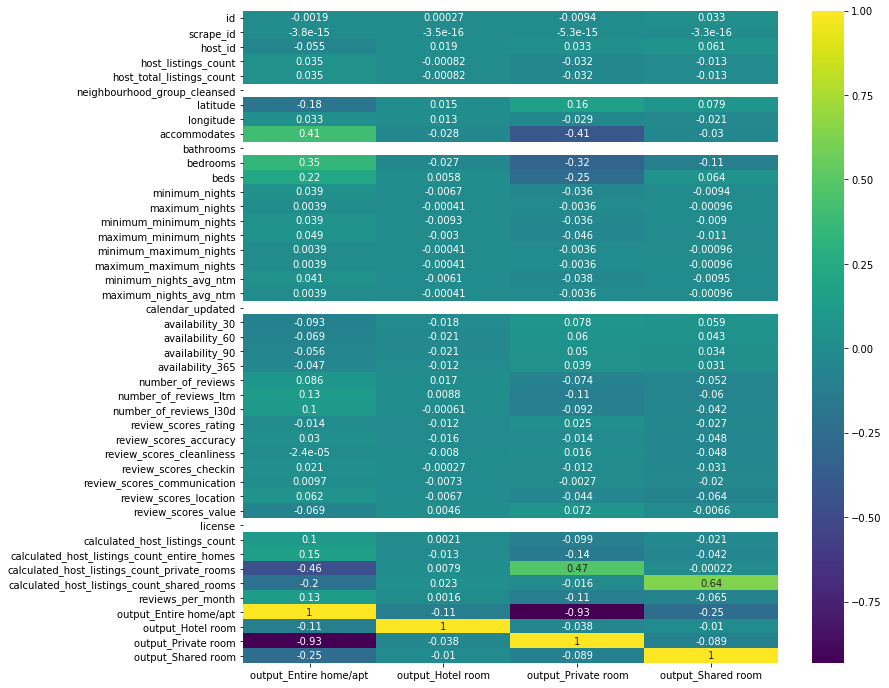

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(listings.corr()[['output_Entire home/apt','output_Hotel room', 'output_Private room', 'output_Shared room']],annot=True,cmap='viridis')

Analisamos de forma análoga cada tipo de room_type e suas correlacoes

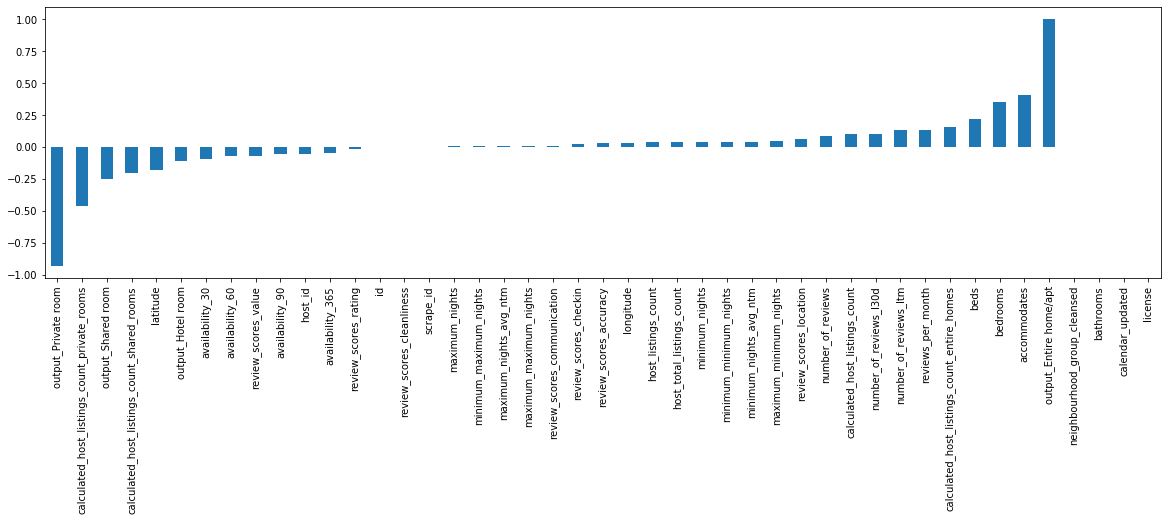

In [9]:
listings.corr()['output_Entire home/apt'].sort_values().plot(kind='bar', figsize=(20,5))

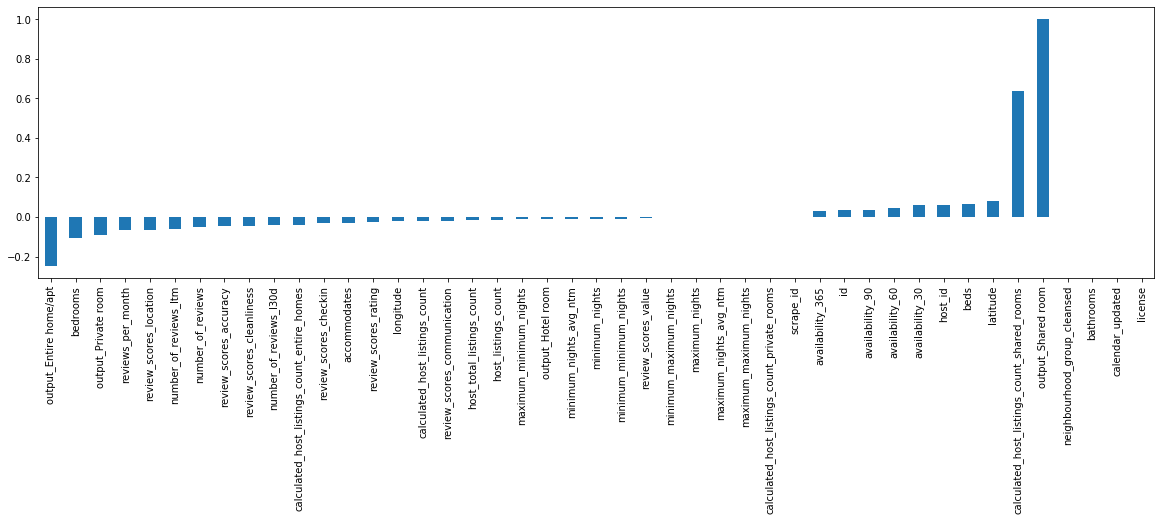

In [10]:
listings.corr()['output_Shared room'].sort_values().plot(kind='bar', figsize=(20,5))

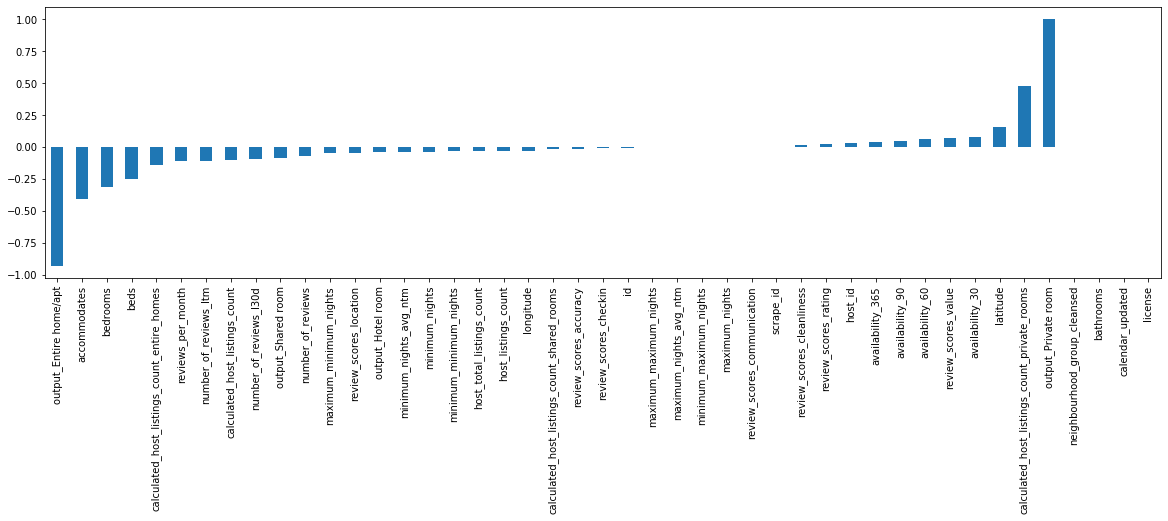

In [11]:
listings.corr()['output_Private room'].sort_values().plot(kind='bar', figsize=(20,5))

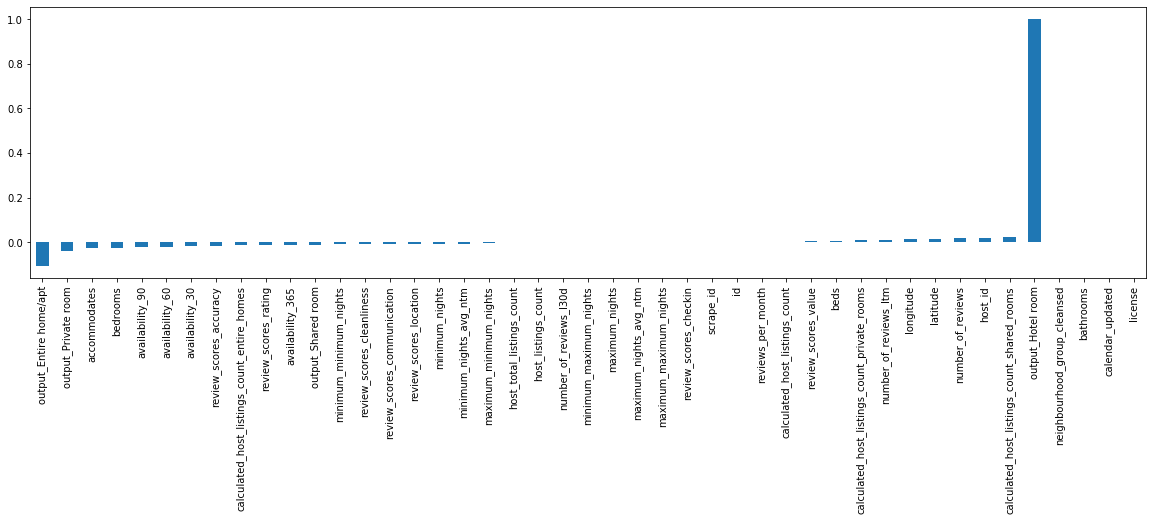

In [12]:
listings.corr()['output_Hotel room'].sort_values().plot(kind='bar', figsize=(20,5))

Analisamos se existe uma maior preponderancia de algum tipo de room_type de acordo com a latitude e longitude

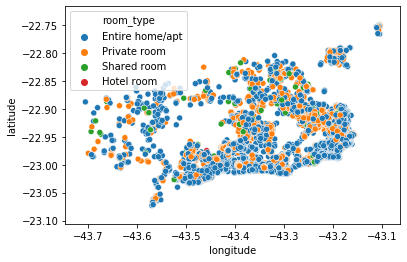

In [13]:
sns.scatterplot(x='longitude',y='latitude',data=listings, hue='room_type')

Analisando room_type com base no numero de beds

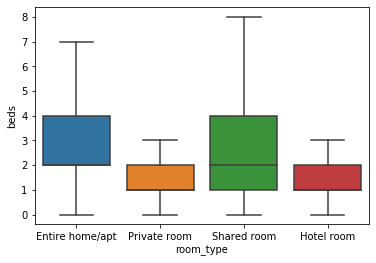

In [14]:
sns.boxplot(x='room_type',y='beds',data=listings,showfliers=False)

Analisando os room_types de acordo com a quantidade de bedrooms

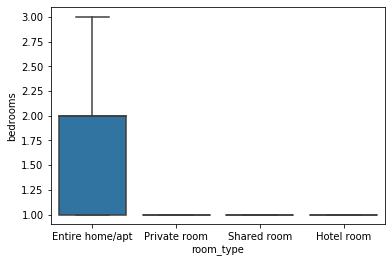

In [15]:
sns.boxplot(x='room_type',y='bedrooms',data=listings,showfliers=False)

Para analisar a variavel price, convertemos ela para uma variavel numerica

In [16]:
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = pd.to_numeric(listings['price'])

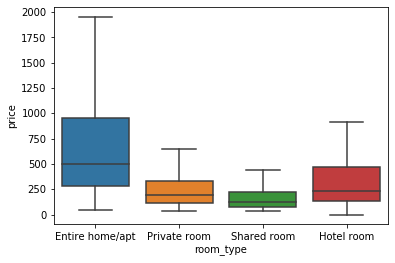

In [17]:
sns.boxplot(x='room_type',y='price',data=listings,showfliers=False)

Analisando a relação de superhosts com o room_type

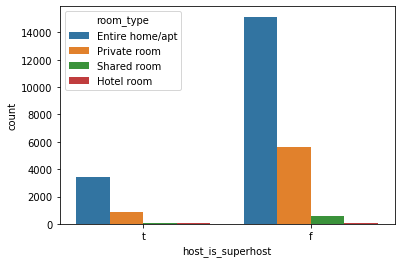

In [18]:
sns.countplot(x='host_is_superhost',data=listings, hue='room_type')

Selecionamos algumas features listadas pra composição do modelo com base na exploração de dados anterior

In [19]:
listings = listings[['host_is_superhost','host_listings_count', 'host_total_listings_count','neighbourhood_cleansed','latitude','longitude','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','price','number_of_reviews','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms', 'output_Entire home/apt','output_Hotel room','output_Private room', 'output_Shared room']]

# Pré processamento de dados

Verificamos que a variavel de bathrooms_text tem um numero de consideravel de valores NaN. Adotamos a estratégia de sustituir os valores NaN com o valor mais frequente da variavel.

In [20]:
listings.isnull().sum()

host_is_superhost                                  8
host_listings_count                                8
host_total_listings_count                          8
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms_text                                    70
bedrooms                                        1726
beds                                             238
price                                              0
number_of_reviews                                  0
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
output_Entire home/apt                        

In [21]:
def fill_bedrooms(bedrooms_df):
    '''
    Checa as linhas contendo valores NaN e sustitui com o valor mais frequente de bedrooms
    '''
    if np.isnan(bedrooms_df):
        return 1
    else:
        return bedrooms_df

In [22]:
listings['bedrooms'] = listings.apply(lambda x: fill_bedrooms(x['bedrooms']), axis=1)

Como o resto das variaveis com valores NaN representa um percentual infimo do total de linhas descartamos as linhas

In [23]:
listings = listings.dropna()

Listamos apenas os bairros relevantes antes de transforma-los em dummy variables

In [24]:
lista_bairros_relevantes = listings['neighbourhood_cleansed'].value_counts()>100

In [25]:
lista_bairros_relevantes = lista_bairros_relevantes.to_frame().reset_index().rename(columns={"neighbourhood_cleansed":"Relevancia","index": "neighbourhood_cleansed"}) 

In [26]:
listings = pd.merge(listings,lista_bairros_relevantes,how='left', on='neighbourhood_cleansed')

In [27]:
listings.loc[listings['Relevancia']==True, 'neighbourhood_cleansed_mod'] = listings['neighbourhood_cleansed']

In [28]:
listings.drop(['Relevancia','neighbourhood_cleansed'],axis=1, inplace=True)

In [29]:
listings = pd.concat([listings, pd.get_dummies(listings['neighbourhood_cleansed_mod'])], axis=1)

In [30]:
listings.drop(['neighbourhood_cleansed_mod'],axis=1, inplace=True)

Calculamos novas features com as diferencas entre o total de listings do host com o total de listings de um especifico room_type. Caso a diferenca seja zero o modelo entendera que trata-se do room_type em questao.

In [31]:
listings['entire_homes_difference'] = listings['calculated_host_listings_count']- listings['calculated_host_listings_count_entire_homes']
listings['private_rooms_difference'] = listings['calculated_host_listings_count']- listings['calculated_host_listings_count_private_rooms']
listings['shared_rooms_difference'] = listings['calculated_host_listings_count']- listings['calculated_host_listings_count_shared_rooms']
listings['hotel_rooms_difference'] = listings['calculated_host_listings_count']- listings['calculated_host_listings_count_shared_rooms']-listings['calculated_host_listings_count_private_rooms']-listings['calculated_host_listings_count_entire_homes']

Tratamos o resto das variaveis para que possam ser treinadas com o modelo

In [32]:
listings.loc[listings['host_is_superhost']=='t','superhost']=1
listings.loc[listings['host_is_superhost']=='f','superhost']=0
listings = listings.drop(['host_is_superhost'],axis=1)

In [33]:
listings = pd.concat([listings,pd.get_dummies(listings['property_type'])],axis=1)
listings = listings.drop(['property_type'], axis=1)

In [34]:
listings['bathrooms'] = listings['bathrooms_text'].str.replace(' bath','')
listings['bathrooms'] = listings['bathrooms'].str.replace('s','')
listings['bathrooms'] = pd.to_numeric(listings['bathrooms'],errors='coerce')
listings = listings.drop(['bathrooms_text'], axis=1)
listings = listings.fillna(0)

In [35]:
listings['hotel_room_proxy']= 0
listings.loc[(listings['calculated_host_listings_count_entire_homes']==0) & (listings['calculated_host_listings_count_shared_rooms']==0) & (listings['calculated_host_listings_count_private_rooms']==0),'hotel_room_proxy']=1

In [36]:
listings= listings.drop(['room_type'],axis=1)

# Train test split

Dividimos o dataset listings em uma parte para treinamento (80%) e outra parte para validaçao (20%)

In [37]:
X = listings.drop(['output_Entire home/apt','output_Hotel room', 'output_Private room', 'output_Shared room'],axis=1).values
y = listings[['output_Entire home/apt','output_Hotel room','output_Private room', 'output_Shared room']].values

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=101)

Normalizamos os dados com MinMaxScaler pra que possam ser treinados

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler = MinMaxScaler()

In [42]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [43]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Criação de Modelo

Construimos um modelo sequencial com Dropout Layers e um call back de early stop para prevenir overfitting no treinamento

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [46]:
model = Sequential()
model.add(Dense(units=60,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=30,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [47]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
638/638 [==============================] - 4s 7ms/step - loss: 0.1459 - val_loss: 0.0180
Epoch 2/600
638/638 [==============================] - 3s 5ms/step - loss: 0.0241 - val_loss: 0.0060
Epoch 3/600
638/638 [==============================] - 4s 6ms/step - loss: 0.0128 - val_loss: 0.0037
Epoch 4/600
638/638 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0025
Epoch 5/600
638/638 [==============================] - 3s 5ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 6/600
638/638 [==============================] - 3s 5ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 7/600
638/638 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 8/600
638/638 [==============================] - 4s 6ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 9/600
638/638 [==============================] - 4s 6ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 10/600
638/638 [==============================] - 4s 6ms/step - loss: 0.0035 - val_lo

Salvando modelo

In [48]:
from tensorflow.keras.models import load_model

In [49]:
model.save('modelo_airbnb.h5')  

# Avaliando a Performance do Modelo

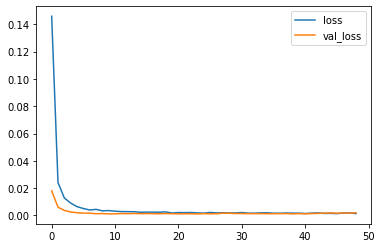

In [50]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [51]:
predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
rounded_y_test = np.argmax(y_test, axis=1)

0 - Entire Home/Apt; 1 - Hotel Room; 2 - Private Room; 3 - Shared Room

In [54]:
print(classification_report(rounded_y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3692
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00      1282
           3       1.00      1.00      1.00       110

    accuracy                           1.00      5100
   macro avg       1.00      1.00      1.00      5100
weighted avg       1.00      1.00      1.00      5100



In [55]:
print(confusion_matrix(rounded_y_test,predictions))

[[3690    0    2    0]
 [   0   16    0    0]
 [   1    0 1281    0]
 [   0    0    0  110]]
